## 데이터 소개

sklearn 에서 제공하는 "fetch_20newsgroups" 라는 데이터셋.      
다음과 같이 20개의 주제에 대해 기사들이, 500~600개 정도씩 존재함. 

In [1]:
from sklearn.datasets import fetch_20newsgroups as newsData
import numpy as np
import pandas as pd
import nltk
from gensim import corpora
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel
from nltk.corpus import stopwords

In [4]:
fullSet = newsData(subset="train",shuffle=True, random_state=4)
fullSet.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [11]:
fullSet.data[2]

'From: kbanaian@bernard.pitzer.claremont.edu (King Banaian)\nSubject: Re: National Sales Tax, The Movie\nLines: 43\nOrganization: Pitzer College\n\nIn article <VEAL.731.734985604@utkvm1.utk.edu> VEAL@utkvm1.utk.edu (David Veal) writes:\n>In article <1993Apr16.164750.21913@alchemy.chem.utoronto.ca> golchowy@\nalchemy.chem.utoronto.ca (Gerald Olchowy) writes:>\n>>In article <9304151442.AA05233@inet-gw-2.pa.dec.com> blh@uiboise.idbsu.edu (Broward L. Horne) writes:\n>>\n>>Why don\'t the Republicans get their act together, and say they\n>>will support a broad-based VAT that would have to be visible\n>>(the VAT in Canada is visible unlike the invisible VATS they\n>>have in Europe)\n>>and suggest a rate sufficient to halve income and corporate\n>>and capital gains tax rates and at a rate sufficient to give\n>>the Clintons enough revenue for their health care reform, \n>\n>       The Republicans are, in general, fighting any tax increase.\n>There is also worry that a VAT would be far too easy 

In [17]:
np.unique(fullSet.target, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 array([480, 584, 591, 590, 578, 593, 585, 594, 598, 597, 600, 595, 591,
        594, 593, 599, 546, 564, 465, 377]))

#### 가장 잘 구분될만한, 이질적인 4가지 주제 선정하여, 4가지에 대해 분류한다.  

In [22]:
partial_categories = ["rec.sport.baseball", "soc.religion.christian", "comp.graphics", "sci.med"]

data_4categories_test = newsData(subset="test", categories = partial_categories, shuffle=True, random_state=4)
data_4categories_train = newsData(subset="train", categories=partial_categories, shuffle=True, random_state=4)

print("test size: ",len(data_4categories_test.data))
print("train size: ",len(data_4categories_train.data))

test size:  1580
train size:  2374


## 데이터 전처리 

주어진 본문을 다음과 같이 전처리한다.    
* 1. 특수문자 제거
* 2. 모두 lower case 로 전환 
* 3. 불용어 제거 

In [30]:
def make_processed_df(data, category_list):
    df = pd.DataFrame({"rawDocument":data.data, "label":data.target})
    df["category"] = df["label"].apply(lambda x :data.target_names[x])
    df["clean_doc"] = df["rawDocument"].str.replace("[^a-zA-Z]", " ").apply(lambda x : ' '.join([w.lower() for w in x.split() if len(w) > 3]))
    stop_words = stopwords.words("english")
    stop_words.extend(["organization", "subject", "lines", "even", "would", "also", "writes", "university", "think", "know", "could", "article", "many", "nntp", "people", "articles" ])

    tokenized_docs= df["clean_doc"].apply(lambda x: x.split())
    df["final_data"] = tokenized_docs.apply(lambda x: [item for item in x if item not in stop_words])
    
    return df

In [31]:
train_df = make_processed_df(data_4categories_train, partial_categories)
test_df = make_processed_df(data_4categories_test, partial_categories)
train_df

,rawDocument,label,category,clean_doc,final_data
0,From: alastair@farli.otago.ac.nz (Alastair Tho...,3,soc.religion.christian,from alastair farli otago alastair thomson sub...,"[alastair, farli, otago, alastair, thomson, ju..."
1,Organization: Penn State University\nFrom: <JE...,0,comp.graphics,organization penn state university from psuvm ...,"[penn, state, psuvm, scanned, grey, color, equ..."
2,From: dingebre@imp.sim.es.com (David Ingebrets...,0,comp.graphics,from dingebre david ingebretsen subject images...,"[dingebre, david, ingebretsen, images, earth, ..."
3,From: drand@spinner.osf.org (Douglas S. Rand)\...,2,sci.med,from drand spinner douglas rand subject chroni...,"[drand, spinner, douglas, rand, chronic, sinus..."
4,From: aardvark@spica.la.locus.com (Warren Usui...,1,rec.sport.baseball,from aardvark spica locus warren usui subject ...,"[aardvark, spica, locus, warren, usui, quick, ..."
...,...,...,...,...,...
2369,From: simon@monu6.cc.monash.edu.au\nSubject: S...,3,soc.religion.christian,from simon monu monash subject saint story alo...,"[simon, monu, monash, saint, story, aloysius, ..."
2370,From: spl@ivem.ucsd.edu (Steve Lamont)\nSubjec...,0,comp.graphics,from ivem ucsd steve lamont subject point with...,"[ivem, ucsd, steve, lamont, point, within, pol..."
2371,From: nfotis@ntua.gr (Nick C. Fotis)\nSubject:...,0,comp.graphics,from nfotis ntua nick fotis subject computer g...,"[nfotis, ntua, nick, fotis, computer, graphics..."
2372,Subject: The 1964 Phillies: deja vu?\nFrom: cs...,1,rec.sport.baseball,subject phillies deja from cabell derby expire...,"[phillies, deja, cabell, derby, expires, virgi..."


In [34]:
train_df.iloc[4,0]

'From: aardvark@spica.la.locus.com (Warren Usui)\nSubject: Re: quick way to tell if your local beat writer is dumb.\nOrganization: Locus Computing Corporation, Los Angeles, California\nLines: 14\n\nIn article <Apr.5.16.22.48.1993.11331@pilot.njin.net> gajarsky@pilot.njin.net (Bob Gajarsky - Hobokenite) writes:\n>anyone who writes "dean palmer has 2 homers  - at this pace, he\'ll\n> have 324 home runs!" should be shot.\n\nThe Dodgers after one inning of play have committed one error.  At this rate\nthey\'ll have 1,455 errors this season!\n\nWell maybe I\'m right this time...\n\n-- \nWarren Usui\n\nI\'m one with the Universe -- on a scale from 1 to 10.\n\n'

In [37]:
train_df.iloc[3,0]

"From: drand@spinner.osf.org (Douglas S. Rand)\nSubject: Re: chronic sinus and antibiotics\nIn-Reply-To: DEHP@calvin.edu's message of Fri, 16 Apr 1993 18:12:14 GMT\nOrganization: Open Software Foundation\n\t<1qk708INNa12@mojo.eng.umd.edu> <DEHP.117@calvin.edu>\nDistribution: na\nLines: 29\n\nIn article <DEHP.117@calvin.edu> DEHP@calvin.edu (Phil de Haan) writes:\n\n   In article <1qk708INNa12@mojo.eng.umd.edu> georgec@eng.umd.edu (George B. Clark) writes:\n   >You can also swab the inside of your nose with Bacitracin using a\n   >Q tip. Bacitracin is an antibiotic that can be bought OTC as an\n   >ointment in a tube. The doctor I listen to on the radio says to apply\n   >it for 30 days, while you are taking other antibiotics by mouth.\n\n   I have a new doctor who gave me a prescription today for something called \n   Septra DS.  He said it may cause GI problems and I have a sensitive stomach \n   to begin with.  Anybody ever taken this antibiotic.  Any good?  Suggestions \n   for avoi

## 모델 학습 

In [38]:
import gensim 

dictionary_train = corpora.Dictionary(train_df["final_data"])
train_corpus = [dictionary_train.doc2bow(text) for text in train_df["final_data"]]



In [44]:
len(train_corpus)

2374

In [47]:
train_corpus[1]

[(9, 1),
 (105, 1),
 (178, 1),
 (191, 1),
 (209, 1),
 (218, 2),
 (226, 1),
 (238, 1),
 (248, 2),
 (269, 1),
 (270, 1),
 (271, 1),
 (272, 1),
 (273, 4),
 (274, 1),
 (275, 1),
 (276, 3),
 (277, 2),
 (278, 1),
 (279, 1),
 (280, 1),
 (281, 1),
 (282, 1),
 (283, 1),
 (284, 1),
 (285, 1),
 (286, 1),
 (287, 1),
 (288, 1),
 (289, 1),
 (290, 1),
 (291, 1),
 (292, 1),
 (293, 1),
 (294, 1),
 (295, 1),
 (296, 1),
 (297, 1),
 (298, 1),
 (299, 1)]

In [48]:
dictionary_train[273]

'color'

In [ ]:
NUM_TOPICS = 4
ldamodel_train = gensim.models.ldamodel.LdaModel(train_corpus, num_topics = NUM_TOPICS, chunksize=20000, iterations=300,  random_state=42, id2word=dictionary_train, passes=30)

In [39]:
for topic in ldamodel_train.print_topics(num_words=15):
    print(topic)

(0, '0.007*"graphics" + 0.007*"image" + 0.004*"posting" + 0.004*"file" + 0.004*"host" + 0.004*"software" + 0.003*"jpeg" + 0.003*"files" + 0.003*"program" + 0.003*"like" + 0.003*"mail" + 0.003*"available" + 0.003*"data" + 0.003*"images" + 0.003*"version"')
(1, '0.006*"jesus" + 0.004*"believe" + 0.004*"christians" + 0.004*"like" + 0.004*"church" + 0.003*"christian" + 0.003*"time" + 0.003*"christ" + 0.003*"bible" + 0.003*"faith" + 0.003*"question" + 0.003*"good" + 0.003*"truth" + 0.003*"life" + 0.003*"science"')
(2, '0.005*"pitt" + 0.004*"gordon" + 0.004*"banks" + 0.003*"food" + 0.003*"health" + 0.003*"like" + 0.003*"medical" + 0.003*"posting" + 0.003*"time" + 0.003*"disease" + 0.003*"host" + 0.003*"reply" + 0.003*"doctor" + 0.002*"david" + 0.002*"patients"')
(3, '0.007*"year" + 0.005*"baseball" + 0.005*"game" + 0.005*"team" + 0.005*"good" + 0.005*"last" + 0.004*"like" + 0.004*"posting" + 0.004*"host" + 0.004*"games" + 0.004*"players" + 0.003*"better" + 0.003*"well" + 0.003*"runs" + 0.003

In [62]:
result_category = {0:"comp.graphics", 1:"soc.religion.christian", 2: "sci.med", 3: "rec.sport.baseball"}
def get_topic(d):
    cat = result_category.get(d[0])
    return cat,d[1]

for i, topic_list in enumerate(ldamodel_train[train_corpus]):
    if i==10:
        break
    answer = [get_topic(x) for x in topic_list]
    print(i,'번째 문서의 topic 비율은',answer)

0 번째 문서의 topic 비율은 [('soc.religion.christian', 0.5508304), ('sci.med', 0.41959256), ('rec.sport.baseball', 0.028795602)]
1 번째 문서의 topic 비율은 [('comp.graphics', 0.75289744), ('sci.med', 0.23640457)]
2 번째 문서의 topic 비율은 [('comp.graphics', 0.7103032), ('sci.med', 0.2834081)]
3 번째 문서의 topic 비율은 [('soc.religion.christian', 0.40151063), ('sci.med', 0.5939254)]
4 번째 문서의 topic 비율은 [('soc.religion.christian', 0.04243501), ('rec.sport.baseball', 0.9468923)]
5 번째 문서의 topic 비율은 [('comp.graphics', 0.021223826), ('sci.med', 0.9750257)]
6 번째 문서의 topic 비율은 [('comp.graphics', 0.08065987), ('sci.med', 0.9041134)]
7 번째 문서의 topic 비율은 [('comp.graphics', 0.20418903), ('soc.religion.christian', 0.7931435)]
8 번째 문서의 topic 비율은 [('rec.sport.baseball', 0.9929372)]
9 번째 문서의 topic 비율은 [('soc.religion.christian', 0.99525994)]


In [65]:
 train_df["final_data"][4]

['aardvark',
 'spica',
 'locus',
 'warren',
 'usui',
 'quick',
 'tell',
 'local',
 'beat',
 'writer',
 'dumb',
 'locus',
 'computing',
 'corporation',
 'angeles',
 'california',
 'pilot',
 'njin',
 'gajarsky',
 'pilot',
 'njin',
 'gajarsky',
 'hobokenite',
 'anyone',
 'dean',
 'palmer',
 'homers',
 'pace',
 'home',
 'runs',
 'shot',
 'dodgers',
 'inning',
 'play',
 'committed',
 'error',
 'rate',
 'errors',
 'season',
 'well',
 'maybe',
 'right',
 'time',
 'warren',
 'usui',
 'universe',
 'scale']

In [40]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel_train, train_corpus, dictionary_train)
pyLDAvis.display(vis)

In [41]:
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

In [42]:
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

## 모델 평가

기존에는 perplexity 와 coherence 를 기준으로 평가 

현재 이 데이터는 category가 존재하므로, 이 category 대로 분류되었는지 평가할 예정 

In [52]:
print("log perplexity : ", ldamodel_train.log_perplexity(train_corpus))

coherencemodel = CoherenceModel(model=ldamodel_train, texts=train_df["final_data"], dictionary=dictionary_train, coherence='c_v')
cv = coherencemodel.get_coherence()
print("coherence : ", cv)

log perplexity :  -8.736770167707448
coherence :  0.5810504900530782


#### 미리 빼두었던 test 데이터에 대해 평가한다. 

In [54]:
test_df

,rawDocument,label,category,clean_doc,final_data
0,From: JEK@cu.nih.gov\nSubject: Relevant Subjec...,3,soc.religion.christian,from subject relevant subject lines lines rece...,"[relevant, recent, post, bears, line, serbian,..."
1,From: mserv@mozart.cc.iup.edu (Mail Server)\nS...,3,soc.religion.christian,from mserv mozart mail server subject homosexu...,"[mserv, mozart, mail, server, homosexual, issu..."
2,From: mls@panix.com (Michael Siemon)\nSubject:...,3,soc.religion.christian,from panix michael siemon subject arsenokoitai...,"[panix, michael, siemon, arsenokoitai, meaning..."
3,From: x91hozak@gw.wmich.edu\nSubject: PRK refe...,2,sci.med,from hozak wmich subject referral canada organ...,"[hozak, wmich, referral, canada, western, mich..."
4,From: ddunlavy@casbah.acns.nwu.edu (Daniel Dun...,0,comp.graphics,from ddunlavy casbah acns daniel dunlavy subje...,"[ddunlavy, casbah, acns, daniel, dunlavy, pict..."
...,...,...,...,...,...
1575,From: daniels@math.ufl.edu (TV's Big Dealer)\n...,3,soc.religion.christian,from daniels math dealer subject deuterocanoni...,"[daniels, math, dealer, deuterocanonicals, sir..."
1576,From: wagner@grace.math.uh.edu (David Wagner)\...,3,soc.religion.christian,from wagner grace math david wagner subject ho...,"[wagner, grace, math, david, wagner, homosexua..."
1577,From: lsvedin@worf (Lynn Svedin)\nSubject: Re:...,3,soc.religion.christian,from lsvedin worf lynn svedin subject mormon t...,"[lsvedin, worf, lynn, svedin, mormon, temples,..."
1578,From: mls@panix.com (Michael Siemon)\nSubject:...,3,soc.religion.christian,from panix michael siemon subject homosexualit...,"[panix, michael, siemon, homosexuality, issues..."


In [67]:
test_corpus = [dictionary_train.doc2bow(text) for text in test_df["final_data"]]
result_test = ldamodel_train.inference(test_corpus)
result_test

(array([[1.1303224e+01, 2.8570185e+01, 1.5860963e+00, 2.6262203e-01],
        [2.2354286e+01, 2.1629143e+02, 1.5258733e+00, 2.6118878e-01],
        [2.5894686e+01, 7.1686078e+02, 2.3803629e+01, 1.2779560e+01],
        ...,
        [4.0349054e+00, 1.2929453e+01, 2.5534686e-01, 3.5403652e+00],
        [2.6635388e-01, 8.8345863e+01, 3.7316172e+00, 2.8164196e-01],
        [1.7167372e+01, 1.8022202e+01, 2.1600084e+00, 5.4125641e+01]],
       dtype=float32),
 None)

In [68]:
test_df["infer_result"] = [ x/sum(x) for x in result_test[0]]
test_df["lda_idx"] = test_df["infer_result"].apply(lambda x: np.argmax(x))
test_df["lda_category"] = test_df["lda_idx"].apply(lambda x : result_category.get(x))
test_df

,rawDocument,label,category,clean_doc,final_data,infer_result,lda_idx,lda_category
0,From: JEK@cu.nih.gov\nSubject: Relevant Subjec...,3,soc.religion.christian,from subject relevant subject lines lines rece...,"[relevant, recent, post, bears, line, serbian,...","[0.27091676, 0.68477297, 0.038015712, 0.006294...",1,soc.religion.christian
1,From: mserv@mozart.cc.iup.edu (Mail Server)\nS...,3,soc.religion.christian,from mserv mozart mail server subject homosexu...,"[mserv, mozart, mail, server, homosexual, issu...","[0.09297521, 0.8995921, 0.0063463617, 0.001086...",1,soc.religion.christian
2,From: mls@panix.com (Michael Siemon)\nSubject:...,3,soc.religion.christian,from panix michael siemon subject arsenokoitai...,"[panix, michael, siemon, arsenokoitai, meaning...","[0.03322649, 0.9198322, 0.030543372, 0.016397955]",1,soc.religion.christian
3,From: x91hozak@gw.wmich.edu\nSubject: PRK refe...,2,sci.med,from hozak wmich subject referral canada organ...,"[hozak, wmich, referral, canada, western, mich...","[0.40462574, 0.27750927, 0.30994618, 0.007918863]",0,comp.graphics
4,From: ddunlavy@casbah.acns.nwu.edu (Daniel Dun...,0,comp.graphics,from ddunlavy casbah acns daniel dunlavy subje...,"[ddunlavy, casbah, acns, daniel, dunlavy, pict...","[0.7443909, 0.005654766, 0.0056143394, 0.24434]",0,comp.graphics
...,...,...,...,...,...,...,...,...
1575,From: daniels@math.ufl.edu (TV's Big Dealer)\n...,3,soc.religion.christian,from daniels math dealer subject deuterocanoni...,"[daniels, math, dealer, deuterocanonicals, sir...","[0.014797057, 0.77662694, 0.20673104, 0.001844...",1,soc.religion.christian
1576,From: wagner@grace.math.uh.edu (David Wagner)\...,3,soc.religion.christian,from wagner grace math david wagner subject ho...,"[wagner, grace, math, david, wagner, homosexua...","[0.03353031, 0.9514315, 0.014115103, 0.0009230...",1,soc.religion.christian
1577,From: lsvedin@worf (Lynn Svedin)\nSubject: Re:...,3,soc.religion.christian,from lsvedin worf lynn svedin subject mormon t...,"[lsvedin, worf, lynn, svedin, mormon, temples,...","[0.19435894, 0.62280387, 0.012299904, 0.17053725]",1,soc.religion.christian
1578,From: mls@panix.com (Michael Siemon)\nSubject:...,3,soc.religion.christian,from panix michael siemon subject homosexualit...,"[panix, michael, siemon, homosexuality, issues...","[0.0028756007, 0.9537966, 0.04028716, 0.003040...",1,soc.religion.christian


In [69]:
test_df.groupby(["category", "lda_category"]).count()

rawDocument  label  clean_doc  \
category               lda_category                                            
comp.graphics          comp.graphics                   375    375        375   
                       rec.sport.baseball                5      5          5   
                       sci.med                           2      2          2   
                       soc.religion.christian            7      7          7   
rec.sport.baseball     comp.graphics                    16     16         16   
                       rec.sport.baseball              372    372        372   
                       sci.med                           1      1          1   
                       soc.religion.christian            8      8          8   
sci.med                comp.graphics                    49     49         49   
                       rec.sport.baseball               19     19         19   
                       sci.med                         237    237        237   
                       soc.religion.christian           91     91         91   
soc.religion.christian comp.graphics                    11     11         11   
                       rec.sport.baseball                1      1          1   
                       sci.med                           1      1          1   
                       soc.religion.christian          385    385        385   

                                               final_data  infer_result  \
category               lda_category                                       
comp.graphics          comp.graphics                  375           375   
                       rec.sport.baseball               5             5   
                       sci.med                          2             2   
                       soc.religion.christian           7             7   
rec.sport.baseball     comp.graphics                   16            16   
                       rec.sport.baseball             372           372   
                       sci.med                          1             1   
                       soc.religion.christian           8             8   
sci.med                comp.graphics                   49            49   
                       rec.sport.baseball              19            19   
                       sci.med                        237           237   
                       soc.religion.christian          91            91   
soc.religion.christian comp.graphics                   11            11   
                       rec.sport.baseball               1             1   
                       sci.med                          1             1   
                       soc.religion.christian         385           385   

                                               lda_idx  
category               lda_category                     
comp.graphics          comp.graphics               375  
                       rec.sport.baseball            5  
                       sci.med                       2  
                       soc.religion.christian        7  
rec.sport.baseball     comp.graphics                16  
                       rec.sport.baseball          372  
                       sci.med                       1  
                       soc.religion.christian        8  
sci.med                comp.graphics                49  
                       rec.sport.baseball           19  
                       sci.med                     237  
                       soc.religion.christian       91  
soc.religion.christian comp.graphics                11  
                       rec.sport.baseball            1  
                       sci.med                       1  
                       soc.religion.christian      385

## 모델의 parameter 설정 

In [75]:
def compute_cp_by_passes(processed_data, limit, start=50, step=50): 
    
    # compute_coherence_perplexity_value(dataInfo["final_data"], limit) 이런식으로 들어간다. 
    dictionary = corpora.Dictionary(processed_data)
    corpus = [dictionary.doc2bow(text) for text in processed_data] 
    coherence_values = []; model_list = []; perplexity=[];
    
    for pass_num in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=4, iterations=300, random_state=42, passes=pass_num) 
        model_list.append(model) 
        pv = model.log_perplexity(corpus)
        perplexity.append(pv)
        
        coherencemodel = CoherenceModel(model=model, texts=processed_data, dictionary=dictionary, coherence='c_v')
        cv = coherencemodel.get_coherence()
        coherence_values.append(cv)
        print("at passNum: ",pass_num, " => cohernce_value: ", cv, ", perplexity: ",pv)
    return model_list, coherence_values, perplexity 

def compute_cp_by_topicNum(processed_data, limit, start=2, step=1): 
    
    # compute_coherence_perplexity_value(dataInfo["final_data"], limit) 이런식으로 들어간다. 
    dictionary = corpora.Dictionary(processed_data)
    corpus = [dictionary.doc2bow(text) for text in processed_data] 
    coherence_values = []; model_list = []; perplexity=[];
    
    for topic_num in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=topic_num, iterations=300, random_state=42, passes=30) 
        model_list.append(model) 
        pv = model.log_perplexity(corpus)
        perplexity.append(pv)
        
        coherencemodel = CoherenceModel(model=model, texts=processed_data, dictionary=dictionary, coherence='c_v')
        cv = coherencemodel.get_coherence()
        coherence_values.append(cv)
        print("at topicNum: ",topic_num, " => cohernce_value: ", cv, ", perplexity: ",pv)
    return model_list, coherence_values, perplexity 

In [76]:
model_list, coherence_value, perplexity = compute_cp_by_passes(train_df["final_data"], 50, start = 5, step=5)

at passNum:  5  => cohernce_value:  0.5173209311914397 , perplexity:  -8.927432670553072
at passNum:  10  => cohernce_value:  0.5512868951265963 , perplexity:  -8.856897543166744
at passNum:  15  => cohernce_value:  0.5599615472311608 , perplexity:  -8.82687398421555
at passNum:  20  => cohernce_value:  0.5620257310064902 , perplexity:  -8.808827245281636
at passNum:  25  => cohernce_value:  0.5620257310064902 , perplexity:  -8.798415666144594
at passNum:  30  => cohernce_value:  0.5620257310064902 , perplexity:  -8.791533951884691
at passNum:  35  => cohernce_value:  0.5469040594524504 , perplexity:  -8.786272557666168
at passNum:  40  => cohernce_value:  0.5469040594524504 , perplexity:  -8.782291988601221
at passNum:  45  => cohernce_value:  0.5469040594524504 , perplexity:  -8.778705026991416


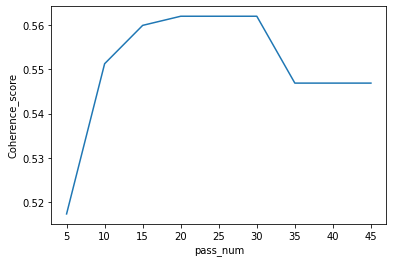

In [79]:
pass_x_range = range(5, 50, 5)

plt.plot(pass_x_range, coherence_value)
plt.xlabel("pass_num")
plt.ylabel("Coherence_score")
plt.show()

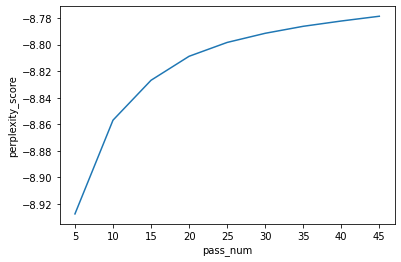

In [80]:
pass_x_range = range(5, 50, 5)

plt.plot(pass_x_range, perplexity)
plt.xlabel("pass_num")
plt.ylabel("perplexity_score")
plt.show()

In [81]:
model_list, coherence_value, perplexity = compute_cp_by_topicNum(train_df["final_data"], 12, start = 2, step=1)

at topicNum:  2  => cohernce_value:  0.39271694786766165 , perplexity:  -8.953143599809486
at topicNum:  3  => cohernce_value:  0.5333638930377379 , perplexity:  -8.834210853627345
at topicNum:  4  => cohernce_value:  0.5620257310064902 , perplexity:  -8.791533951884691
at topicNum:  5  => cohernce_value:  0.47375831391123063 , perplexity:  -8.823012622394314
at topicNum:  6  => cohernce_value:  0.4504139660708723 , perplexity:  -8.841030543093504
at topicNum:  7  => cohernce_value:  0.43700346222542474 , perplexity:  -8.868641256696405
at topicNum:  8  => cohernce_value:  0.5125127777054987 , perplexity:  -8.879752224972346
at topicNum:  9  => cohernce_value:  0.437968296411448 , perplexity:  -8.888563247025083
at topicNum:  10  => cohernce_value:  0.4915972135750075 , perplexity:  -8.890363876604253
at topicNum:  11  => cohernce_value:  0.49989588748638436 , perplexity:  -8.875384892183954


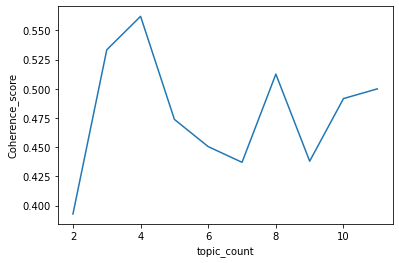

In [82]:
pass_x_range = range(2, 12, 1 )

plt.plot(pass_x_range, coherence_value)
plt.xlabel("topic_count")
plt.ylabel("Coherence_score")
plt.show()

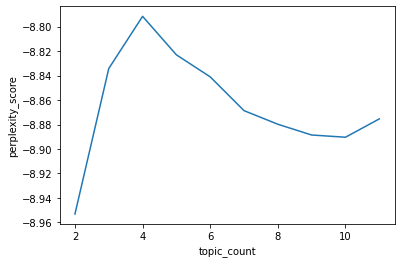

In [83]:
pass_x_range = range(2, 12, 1 )

plt.plot(pass_x_range, perplexity)
plt.xlabel("topic_count")
plt.ylabel("perplexity_score")
plt.show()

In [85]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model_list[9], train_corpus, dictionary_train)
pyLDAvis.display(vis)

## Model load -> save -> predict

#### 모델을 저장한다. 

In [86]:
lda_train_model_path = "./lda_model/train0916/model1"
ldamodel_train.save(lda_train_model_path)

#### 저장한 모델을 load 한다. 

In [87]:
loaded_model = gensim.models.ldamodel.LdaModel.load(lda_train_model_path)
loaded_model

In [88]:
test_corpus_from_loaded = [loaded_model.id2word.doc2bow(text) for text in test_df["final_data"]]
loaded_result = loaded_model.inference(test_corpus_from_loaded)

test_df["infer_result_loaded"] = [ x/sum(x) for x in loaded_result[0]]
test_df["lda_idx_loaded"] = test_df["infer_result_loaded"].apply(lambda x: np.argmax(x))
test_df["lda_category_loaded"] = test_df["lda_idx_loaded"].apply(lambda x : result_category.get(x))
test_df

,rawDocument,label,category,clean_doc,final_data,infer_result,lda_idx,lda_category,infer_result_loaded,lda_idx_loaded,lda_category_loaded
0,From: JEK@cu.nih.gov\nSubject: Relevant Subjec...,3,soc.religion.christian,from subject relevant subject lines lines rece...,"[relevant, recent, post, bears, line, serbian,...","[0.27091676, 0.68477297, 0.038015712, 0.006294...",1,soc.religion.christian,"[0.27090907, 0.6847567, 0.03803972, 0.0062945336]",1,soc.religion.christian
1,From: mserv@mozart.cc.iup.edu (Mail Server)\nS...,3,soc.religion.christian,from mserv mozart mail server subject homosexu...,"[mserv, mozart, mail, server, homosexual, issu...","[0.09297521, 0.8995921, 0.0063463617, 0.001086...",1,soc.religion.christian,"[0.0929751, 0.8995918, 0.0063467296, 0.0010863...",1,soc.religion.christian
2,From: mls@panix.com (Michael Siemon)\nSubject:...,3,soc.religion.christian,from panix michael siemon subject arsenokoitai...,"[panix, michael, siemon, arsenokoitai, meaning...","[0.03322649, 0.9198322, 0.030543372, 0.016397955]",1,soc.religion.christian,"[0.033225175, 0.91983306, 0.03054354, 0.016398...",1,soc.religion.christian
3,From: x91hozak@gw.wmich.edu\nSubject: PRK refe...,2,sci.med,from hozak wmich subject referral canada organ...,"[hozak, wmich, referral, canada, western, mich...","[0.40462574, 0.27750927, 0.30994618, 0.007918863]",0,comp.graphics,"[0.4046297, 0.2775202, 0.30993125, 0.007918872]",0,comp.graphics
4,From: ddunlavy@casbah.acns.nwu.edu (Daniel Dun...,0,comp.graphics,from ddunlavy casbah acns daniel dunlavy subje...,"[ddunlavy, casbah, acns, daniel, dunlavy, pict...","[0.7443909, 0.005654766, 0.0056143394, 0.24434]",0,comp.graphics,"[0.74439806, 0.0056547793, 0.005614349, 0.2443...",0,comp.graphics
...,...,...,...,...,...,...,...,...,...,...,...
1575,From: daniels@math.ufl.edu (TV's Big Dealer)\n...,3,soc.religion.christian,from daniels math dealer subject deuterocanoni...,"[daniels, math, dealer, deuterocanonicals, sir...","[0.014797057, 0.77662694, 0.20673104, 0.001844...",1,soc.religion.christian,"[0.014791182, 0.7766312, 0.20673266, 0.0018449...",1,soc.religion.christian
1576,From: wagner@grace.math.uh.edu (David Wagner)\...,3,soc.religion.christian,from wagner grace math david wagner subject ho...,"[wagner, grace, math, david, wagner, homosexua...","[0.03353031, 0.9514315, 0.014115103, 0.0009230...",1,soc.religion.christian,"[0.03353056, 0.95143205, 0.014114338, 0.000923...",1,soc.religion.christian
1577,From: lsvedin@worf (Lynn Svedin)\nSubject: Re:...,3,soc.religion.christian,from lsvedin worf lynn svedin subject mormon t...,"[lsvedin, worf, lynn, svedin, mormon, temples,...","[0.19435894, 0.62280387, 0.012299904, 0.17053725]",1,soc.religion.christian,"[0.19429684, 0.622859, 0.012299901, 0.17054427]",1,soc.religion.christian
1578,From: mls@panix.com (Michael Siemon)\nSubject:...,3,soc.religion.christian,from panix michael siemon subject homosexualit...,"[panix, michael, siemon, homosexuality, issues...","[0.0028756007, 0.9537966, 0.04028716, 0.003040...",1,soc.religion.christian,"[0.002875613, 0.953799, 0.04028441, 0.003040976]",1,soc.religion.christian


In [89]:
test_df.groupby(["lda_category", "lda_category_loaded"]).count()

,,rawDocument,label,category,clean_doc,final_data,infer_result,lda_idx,infer_result_loaded,lda_idx_loaded
lda_category,lda_category_loaded,,,,,,,,,
comp.graphics,comp.graphics,451,451,451,451,451,451,451,451,451
rec.sport.baseball,rec.sport.baseball,397,397,397,397,397,397,397,397,397
sci.med,sci.med,241,241,241,241,241,241,241,241,241
soc.religion.christian,soc.religion.christian,491,491,491,491,491,491,491,491,491
